<a href="https://colab.research.google.com/github/Kanekohe/master-thesis/blob/main/Gibbs_Sampler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Gibbs samplingの例

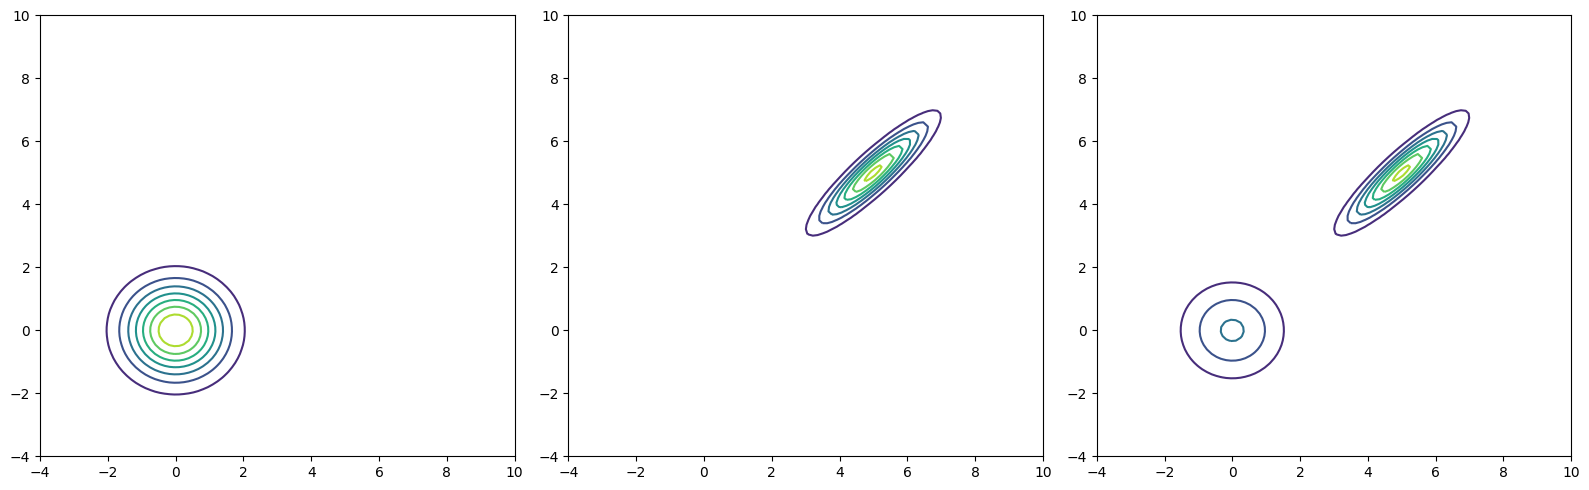

In [ ]:
import numpy as np
import seaborn as sns
import scipy.stats as st
from matplotlib import pyplot as plt

mus = np.array([[0, 0],[5,5]])
sigmas = np.array([[[1, 0.], [0., 1]],[[1,.9],[.9,1.]]])

#print(mus[0,:])
#print(sigmas[1,:])

def pgauss(x, y, z):
    return st.multivariate_normal.pdf([x, y], mean=mus[z,:], cov=sigmas[z,:])

def mixture(x, y):
    return pgauss(x,y,0)+pgauss(x,y,1)

fig = plt.figure(dpi=100, figsize=(16,5))
ax1 = fig.add_subplot(1, 3, 1)
ax2 = fig.add_subplot(1, 3, 2)
ax3 = fig.add_subplot(1, 3, 3)

xvar = np.linspace(-4.0, 10.0, 100)
yvar = np.linspace(-4.0, 10.0, 100)
zvar = np.array([[pgauss(u,v,0) for u in xvar] for v in yvar])
ax1.contour(xvar,yvar,zvar)
zvar = np.array([[pgauss(u,v,1) for u in xvar] for v in yvar])
ax2.contour(xvar,yvar,zvar)
zvar = np.array([[mixture(u,v) for u in xvar] for v in yvar])
ax3.contour(xvar,yvar,zvar)
fig.tight_layout()             
plt.show()


## 二次元ガウス分布からのサンプリングをGibbs samplingで
二変数の確率変数を$(x,y)=\vec{x}$として，その確率密度関数がガウス分布
$$
P(x,y) \propto \exp\left(\frac{1}{2}(\vec{x}-\vec{\mu})^T \Sigma^{-1} (\vec{x}-\vec{\mu})\right)
$$
とする．ここで,$\vec{\mu}=(\mu_x,\mu_y)$は期待値, $\Sigma$は分散共分散行列である．

Gibbs samplingでは，サンプル変数以外の変数は現在の値に止めておいて，サンプルする変数をその止めた値の条件付き確率分布から提案する．
例えば，$t$ステップ後のサンプル点を$(x_t,y_t)$として，$x_{t+1}$をサンプル数するときには，
$$
x_{t+1} \sim P(x|y_t)
$$
となる．具体的な条件付き確率分布$P(x|y)$は，
$$
P(x|y) = N(\mu_x+\Sigma_{xy}\Sigma_{yy}^{-1}(y-\mu_y), \Sigma_{xx}-\Sigma_{xy}\Sigma_{yy}^{-1}\Sigma_{yx})
$$
と，修正されたガウス分布で表されるために，容易に提案できる．Gibbs samplingの特徴はその提案が確率１で採択されることである．

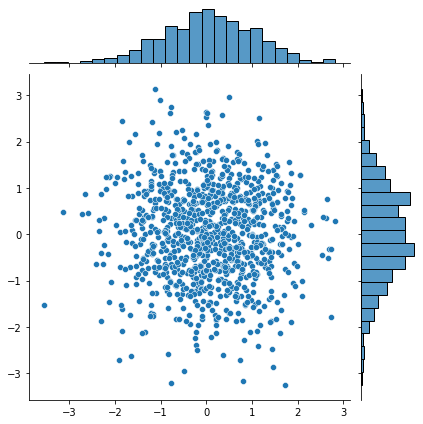

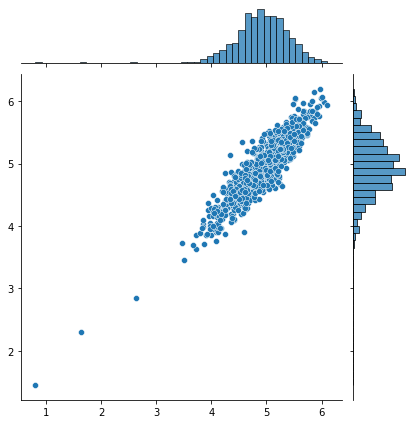

In [ ]:
def p_x_given_y(y, mus, sigmas):
#    mu = mus[0] + sigmas[1, 0] / sigmas[0, 0] * (y - mus[1])
    mu = mus[0] + sigmas[1, 0] / sigmas[1, 1] * (y - mus[1])
    sigma = sigmas[0, 0] - sigmas[1, 0] / sigmas[1, 1] * sigmas[1, 0]
    return np.random.normal(mu, sigma)

def p_y_given_x(x, mus, sigmas):
#    mu = mus[1] + sigmas[0, 1] / sigmas[1, 1] * (x - mus[0])
    mu = mus[1] + sigmas[0, 1] / sigmas[0, 0] * (x - mus[0])
    sigma = sigmas[1, 1] - sigmas[0, 1] / sigmas[0, 0] * sigmas[0, 1]
    return np.random.normal(mu, sigma)

def gibbs_sampling(mus, sigmas, iter=1000):
    samples = np.zeros((iter, 2))
#    y = np.random.rand() * 10
    x, y=.0, .0
    
    for i in range(iter):
        x = p_x_given_y(y, mus, sigmas)
        y = p_y_given_x(x, mus, sigmas)
        samples[i, :] = [x, y]
    return samples


if __name__ == '__main__':
    mus = np.array([[0, 0],[5,5]])
    sigmas = np.array([[[1, 0.], [0., 1]],[[1,.9],[.9,1]]])

    samples = gibbs_sampling(mus[0,:], sigmas[0,:])
    sns.jointplot(x=samples[:, 0], y=samples[:, 1])
    
    samples = gibbs_sampling(mus[1,:], sigmas[1,:])
    sns.jointplot(x=samples[:, 0], y=samples[:, 1])
    

## 混合ガウス分布からのサンプリング
$$
P(x,y) \propto \sum_{i=0,1} \pi_i \exp\left(\frac{1}{2}(\vec{x}-\vec{\mu}_i)^T \Sigma^{-1}_i (\vec{x}-\vec{\mu}_i)\right)
$$
隠れ変数Zを導入．$z\in (0,1)$
$$
P(x,y,z) \propto \sum_{i=0,1} \pi_i \exp\left(\frac{1}{2}(\vec{x}-\vec{\mu}_i)^T \Sigma^{-1}_i (\vec{x}-\vec{\mu}_i)\right)\delta(z,i)
$$
この３変数に関してGibbs samplingしてみる．

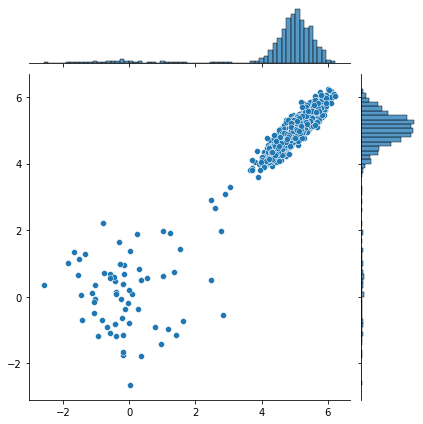

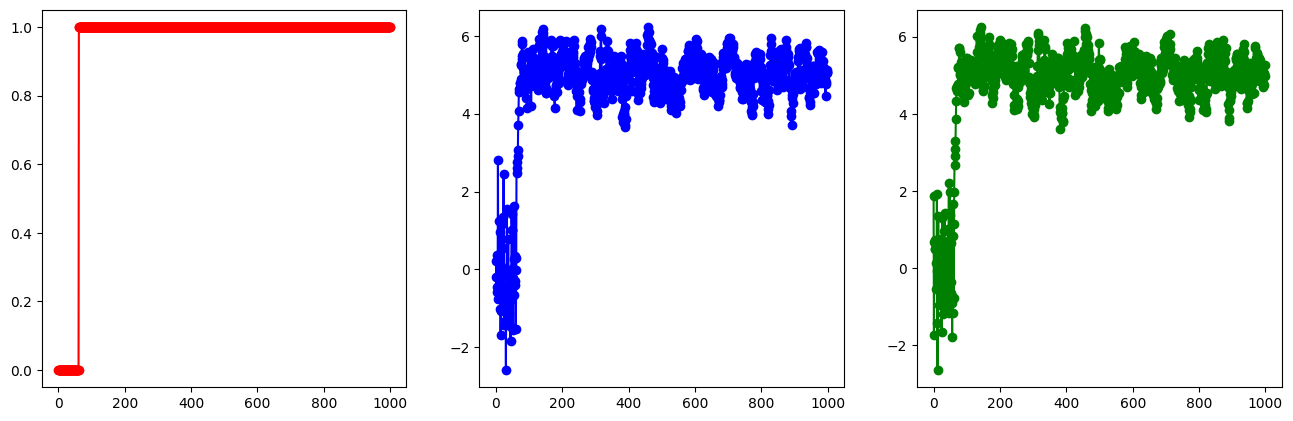

In [ ]:
def p_z_given_xy(x, y, mus,sigmas):
    if np.random.rand() < pgauss(x, y, 0) / mixture(x, y):
        z = 0
    else:
        z = 1
    return z

def gibbs_sampling_mixture(mus, sigmas, iter=2000):
    samples = np.zeros((iter, 2))
    hidden = np.zeros(iter)
#    y = np.random.rand() * 10
    x, y, z = -.0, 0.0, 0
    
    for i in range(iter):
        x = p_x_given_y(y, mus[z,:], sigmas[z,:])
        y = p_y_given_x(x, mus[z,:], sigmas[z,:])
        z = p_z_given_xy(x,y, mus, sigmas)
        samples[i, :] = [x, y]
        hidden[i] = z
    return samples,hidden


if __name__ == '__main__':
    mus = np.array([[0, 0],[5,5]])
    sigmas = np.array([[[1, 0.], [0., 1]],[[1,.9],[.9,1]]])

    iter=1000
    samples, hidden = gibbs_sampling_mixture(mus, sigmas,iter)
    sns.jointplot(x=samples[:, 0], y=samples[:, 1])
    plt.show()
    fig = plt.figure(dpi=100, figsize=(16,5))
    plt.subplot(1,3,1)
    plt.plot(np.arange(iter), hidden[:],marker="o",color="r")
    plt.subplot(1,3,2)
    plt.plot(np.arange(iter), samples[:,0],marker="o",color="b")
    plt.subplot(1,3,3)
    plt.plot(np.arange(iter), samples[:,1],marker="o",color="g") 
    plt.show()